In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
words = open('names.txt', 'r').read().splitlines()

In [3]:
words[:5]

['emma', 'olivia', 'ava', 'isabella', 'sophia']

In [6]:
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i, s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [12]:
def process_data(block_size, words, num_words = None):
    X, Y = [], []

    if not num_words: num_words = len(words)

    for w in words[:num_words]:
        context = [0] * block_size # initial context is just '.' * n (beggining of word)
        for char in w + '.':
            ix = stoi[char]
            X.append(context)
            Y.append(ix)
            # print(''.join(itos[c] for c in context), '--->', char)
            context = context[1:] + [ix]
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    return X, Y

process_data(4, words, 5);

### What is an MLP

Refer to this [paper](https://www.jmlr.org/papers/volume3/bengio03a/bengio03a.pdf) to read more.

This is essentially our architecture: ![img](https://miro.medium.com/v2/resize:fit:1400/1*EqKiy4-6tuLSoPP_kub33Q.png)
Main idea of paper:
 - Hard to approximate discrete joint probability distribution of NLP tasks magnitude
 - Instead we can "learn" how to convert contexts/previous data into a feature vector in $\mathbb{R}^m$ (this is what C is doing)
 - In this way we can approximate a smooth/continuous probability distribution
 - Also has added benefits that similar words syntactically and semantically will be neighboring vectors, so even if we encounter data that is not exactly included in training we can generalize somewhat
 - Furthermore we see that we can embed these vectors in a lower dimensional space. i.e. in the paper, they embed words from a vocabulary of 17,000 into vectors in as small spaces as $\mathbb{R}^30$.
 - So for our task with only 27 possible characters we won't need to work with high dim vectors only in order of $\mathbb{R}^2$ or $\mathbb{R}^3$

### How do we embed?
 - Previously we used one-hot encoding to turn character indexes into vectors of dim 27, and then used matrix multiplication to retrieve the necessary numbers
 - In bigrams we see that the same result could've been achieved by simple row indexing b/c the 0's act as a mask and we only multiply the index of interest by 1 so it is preserved
 - Pytorch allows us to use powerful indexing methods so that for the entire dataset X, we can simply index the necessary vectors using $C[X]$.
 - If X is using say a block size of 3, and has $m$ examples it is m x 3. C[X] m x 3 x n where n is the number of columns of C. For every number in X, we treated it as a row index.

In [13]:
X, Y = process_data(3, words)

# Can embed vectors in R^2
C = torch.randn((27, 2))

In [14]:
emb = C[X]

emb.shape

torch.Size([228146, 3, 2])

In [28]:
# For our hidden layer we will have 3x2 = 6 inputs (3 2D vectors which we can flatten into 1 6D), 
# number of neurons in this layer is up to our discretion
W1 = torch.randn((6, 100))
b1 = torch.randn(100)

e1 = emb.reshape((228146, 6))

e2 = torch.cat((emb[:, 0, :],emb[:, 1, :], emb[:, 2, :]), 1)

torch.allclose(e1, e2) # We see that these are both valid ways to reshape embedding vector

True

In [27]:
# Other way:
e3 = torch.cat(torch.unbind(emb, 1), 1)

torch.allclose(e1, e3)

True

In [26]:
# The most efficient way however is to use torch.tensor.view(). This is because it doesn't move, copy, or iterate over memory
# All it does is change internal attributes such as _size and _stride of torch.tensor 
# so it changes how we see/represent the same data (reshape uses view when possible, copies memory if necessary). Note
# that view only works when we want to view tensor in specific shapes/subspaces, idk look up the rules if you need

e4 = emb.view((228146, -1))

torch.allclose(e1, e4)

True

In [33]:
# Now we can get output of hidden layer like so:
h = torch.tanh(emb.view((-1, 6)) @ W1 + b1)

# Note the broadcasting here: 
# matrix product is m x 100 
# b1 is (, 100) so treated as 1 x 100 row vector and applied to each row of matrix product (this is what we want in this case)
h.shape

torch.Size([228146, 100])

In [35]:
# Last layer input is 100, output is 27 for each character
W2 = torch.randn((100, 27))
b2 = torch.randn(27)

probs = torch.softmax((h @ W2 + b2), 1)

In [37]:
probs.sum(1).shape

torch.Size([228146])

### Why use F.cross_entropy
 - Same exact computation
 - Reduces amount of memory created to compute loss
 - Is more numerically stable. I.e avoids 'inf' issues by subtracting by max(logit) before computing torch.exp()
 - Much simpler to compute backward pass of full cross_entropy loss instead of computing backward pass of each individual computation (recall that gradient of cross entropy is actually a simple expression based on loss.data)


In [ ]:
# Now let's formally organize this NN:

In [76]:
# Data
X, Y = process_data(block_size=3, words=words)

# Params
g=torch.Generator().manual_seed(2147483647)
C = torch.randn((27, 2), generator=g, requires_grad=True)
W1 = torch.randn((6, 100), generator=g, requires_grad=True)
b1 = torch.randn(100, generator=g, requires_grad=True)
W2 = torch.randn((100, 27), generator=g, requires_grad=True)
b2 = torch.randn(27, generator=g, requires_grad=True)
params = [C, W1, b1, W2, b2]

In [63]:
# Number of parameters:
sum(p.nelement() for p in params)

3481

In [120]:
# Notice that descent takes a long time to compute. We need to use BGD so we are not computing full gradient for entire dataset
# every time. It is much better and more efficient to follow approximate gradient with more steps than the exact gradient with
# fewer steps
def descent(iters, lr, batch_sz, data, labels):
    for i in range(iters):
        # Get a batch of data by randomly selecting row indices for X and Y
        batch = torch.randint(0, data.shape[0], (batch_sz, ))
        
        # Forward pass:
        emb = C[data[batch]]
        h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
        logits = h@W2 + b2
        loss = F.cross_entropy(logits, labels[batch]) # cross entropy takes in logits, not probabilities
        # if i%10==0:print(loss.item())
        
        # Backward pass:
        for p in params:
            p.grad=None
        loss.backward()
        for p in params:
            p.data += -lr*p.grad

descent(100, 0.01, 32, X, Y)

In [100]:
# This snippet is to print full loss after batch training
emb = C[X]
h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
logits = h@W2 + b2
loss = F.cross_entropy(logits, Y) 
loss

tensor(2.3024, grad_fn=<NllLossBackward0>)

### How to determine a reasonable learning rate?

 - Find an upper and lower bound where if exceeded, descent is no longer really optimizing
 - Can use torch or `np.linspace(lower, upper, steps)` to get all possible learning rates
 - Throughout descent change lr each time and track stats (i.e. at learning rate i, achieved loss i)
 - Plot this, use a valley in loss where it's fairly stable (not going up and down much) as learning rate
 - From the plot below we can see that a good learning rate here is around 0.1 or 0.2
 - Towards the end of training we can use learning rate decay to improve loss

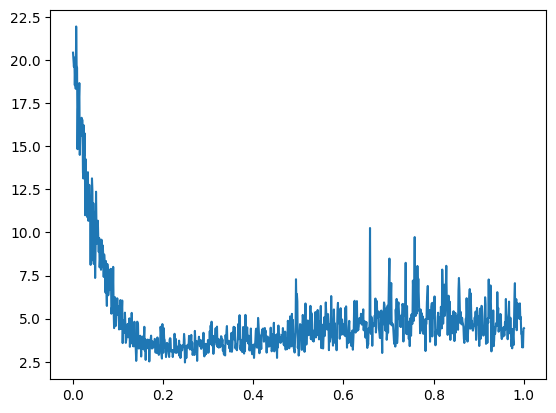

In [73]:
# Here is this process visualized:
lrs = torch.linspace(1e-3, 1, 1000)

def descent_stats(iters, batch_sz):
    lossi = []
    for i in range(iters):
        # Get a batch of data by randomly selecting row indices for X and Y
        batch = torch.randint(0, X.shape[0], (batch_sz, ))
        
        # Forward pass:
        emb = C[X[batch]]
        h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
        logits = h@W2 + b2
        loss = F.cross_entropy(logits, Y[batch]) # cross entropy takes in logits, not probabilities
        
        # Backward pass:
        for p in params:
            p.grad=None
        loss.backward()

        lr = lrs[i]
        for p in params:
            p.data += -lr*p.grad

        # update stats
        lossi.append(loss.item())
    return lossi

losses = descent_stats(1000, 32)
plt.plot(lrs, losses)

### On model size and loss
 - As model grows in parameters, it will be able to overfit the data exactly and we will eventually be able to to get 0 loss
 - This isn't valuable however because it essentially only memorizes the training data. Won't be able to generate anything new/useful anymore
 - For this reason we split data into training, dev/validation, and testing splits
 - If we see that the loss of training and dev are roughly equal after training this is known as "underfitting"
This means that we can __improve performance by increasing the size of our model__


In [121]:
# Let's generate these splits by changing up our process_data function
import random
random.seed(42)
random.shuffle(words) # does this in-place

n1, n2 = int(0.8 * len(words)), int(0.9 * len(words))
trX, trY = process_data(3, words[:n1])
devX, devY = process_data(3, words[n1:n2])
testX, testY = process_data(3, words[n2:])

In [122]:
# I will now go back up, reset parameters and redo training and testing

# Params
g=torch.Generator().manual_seed(2147483647)
C = torch.randn((27, 2), generator=g, requires_grad=True)
W1 = torch.randn((6, 100), generator=g, requires_grad=True)
b1 = torch.randn(100, generator=g, requires_grad=True)
W2 = torch.randn((100, 27), generator=g, requires_grad=True)
b2 = torch.randn(27, generator=g, requires_grad=True)
params = [C, W1, b1, W2, b2]

In [128]:
descent(iters=20000 , lr=0.1 , batch_sz=32 , data=trX, labels=trY)

In [129]:
# Evaluating model on dev loss:
emb = C[devX]
h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits,devY)
print(f'dev loss = {loss.item()}')

# Checking training loss:
emb = C[trX]
h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits,trY)
print(f'training loss = {loss.item()}')

dev loss = 2.420773983001709
training loss = 2.4073550701141357


In [188]:
# We see that dev and training loss is about the same therefore we are underfitting and would benefit from a larger model 
# with more parameters

# Issue is a lot of our stuff is hardcoded so we must refactor our codebase a bit
# # New Params, we will increase size of hidden layer and dimensionality of embedding
# g=torch.Generator().manual_seed(2147483647)
# C = torch.randn((27, 8), generator=g, requires_grad=True)
# W1 = torch.randn((24, 200), generator=g, requires_grad=True)
# b1 = torch.randn(200, generator=g, requires_grad=True)
# W2 = torch.randn((200, 27), generator=g, requires_grad=True)
# b2 = torch.randn(27, generator=g, requires_grad=True)
# params = [C, W1, b1, W2, b2]

lossi, stepi = [], []
def descent(iters, lr, batch_sz, data, labels, decay_threshold = float('inf'), beta = 1e-3):
    for i in range(iters):
        # Get a batch of data by randomly selecting row indices for X and Y
        batch = torch.randint(0, data.shape[0], (batch_sz, ))
        
        # Forward pass:
        emb = C[data[batch]]
        h = torch.tanh(emb.view(-1, emb.shape[1]*emb.shape[2]) @ W1 + b1)
        logits = h@W2 + b2
        loss = F.cross_entropy(logits, labels[batch])
        loss += beta * ((W1**2).mean() + (W2**2).mean() + (C**2).mean()) # With regularization
        # if i%10==0:print(loss.item())
        
        # Backward pass:
        for p in params:
            p.grad=None
        loss.backward()
        for p in params:
            if iters < decay_threshold:
                p.data += -lr*p.grad
            else:
                p.data += -(lr * 2e-1)*p.grad
                

        # # track some stats
        # stepi.append(i)
        # lossi.append(loss.item())

def eval_loss(data, labels):
    emb = C[data]
    h = torch.tanh(emb.view(-1, emb.shape[1]*emb.shape[2]) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, labels)
    return loss

In [146]:
descent(10000, lr = 0.005, batch_sz = 112, data=trX, labels=trY) # training new, bigger model

#peep the dev and training loss
eval_loss(devX, devY).item(), eval_loss(trX, trY).item()

(2.173098087310791, 2.1485660076141357)

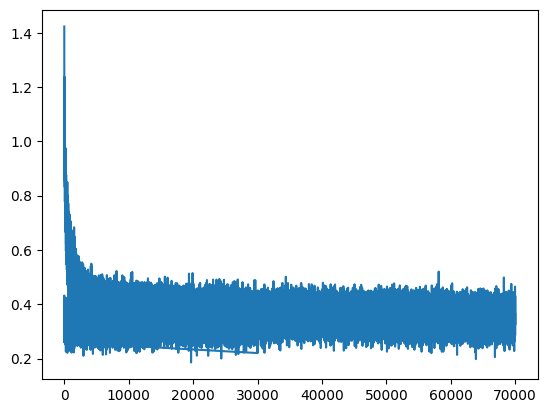

In [145]:
plt.plot(stepi, torch.log10(torch.tensor(lossi)).data)

In [189]:
# Let's try to beat this loss by evaluating words based on 5 characters worth of context instead of the previous
random.shuffle(words) # does this in-place

# New data:
n1, n2 = int(0.8 * len(words)), int(0.9 * len(words))
trX, trY = process_data(4, words[:n1])
devX, devY = process_data(4, words[n1:n2])
testX, testY = process_data(4, words[n2:])

# New params:
C = torch.randn((27, 10), generator=g, requires_grad=True)
W1 = torch.randn((40, 400), generator=g, requires_grad=True)
b1 = torch.randn(400, generator=g, requires_grad=True)
W2 = torch.randn((400, 27), generator=g, requires_grad=True)
b2 = torch.randn(27, generator=g, requires_grad=True)
params = [C, W1, b1, W2, b2]

# Initial losses of training and dev:
eval_loss(devX, devY).item(), eval_loss(trX, trY).item()

(37.25190353393555, 37.18149185180664)

In [190]:
# Number of parameters:
sum(p.nelement() for p in params)

27497

In [300]:
# Training:
descent(iters=50, lr=0.0005, batch_sz=10000, data=trX, labels=trY, beta = 5e-2)

# Final losses of training and dev:
eval_loss(devX, devY).item(), eval_loss(trX, trY).item()

(2.150073528289795, 2.1234500408172607)

In [303]:
# Sample from the model:
def sample(num, block_sz):
    for _ in range(num):
        context = [0]*block_sz
        out=[]
        while True:
            emb = C[torch.tensor(context)]
            h = torch.tanh(emb.view(1, -1) @ W1 + b1)
            logits = h @ W2 + b2
            probs = F.softmax(logits, dim=1)
            ix = torch.multinomial(probs, num_samples=1, replacement=True).item()
            context = context[1:] + [ix]
            if ix == 0:
                break
            out.append(ix)
        print(''.join(itos[i] for i in out))

sample(10, 4)

hand
rooman
decmuryan
arisson
crgstiele
jazon
makkika
kayzel
nackiss
xiynnn


In [288]:
eval_loss(testX, testY)

tensor(2.1550, grad_fn=<NllLossBackward0>)

### Conclusion

As we can see from our model sampling and our loss, this MLP approach to LMs is much more effective and accurate compared to n-grams. 